# VQE を使用した分子のシミュレーション

このチュートリアルでは、変分量子固有ソルバー (VQE) を紹介し、その使用を動機付け、必要な理論を説明し、分子の基底状態エネルギーを見つける際の実装を示します。

## 序章

多くのアプリケーションでは、行列の最小固有値を見つけることが重要です。たとえば、化学では、分子を特徴付けるエルミート行列の最小固有値は、その系の基底状態エネルギーです。将来的には、量子位相推定アルゴリズムが最小固有値を見つけるために使用される可能性があります。ただし、有用な問題を実装するには、NISQ 時代に利用可能なハードウェアの限界を超える回路深さが必要です。そこで、2014 年に Peruzzo*らは*、は、はるかに浅い回路を使用して分子の基底状態エネルギーを推定する VQE を提案しました [1]。

正式に述べると、固有状態 $|\psi_{\text{min}}\rangle$ に関連付けられた未知の最小固有値 $\lambda_{\text{min}}$ を持つエルミート行列 $H$ が与えられると、VQE は推定値を提供します。 $\lambda_{\theta}$ 境界 $\lambda_{\text{min}}$:

$$
\begin{aligned}
    \lambda_{\text{min}} \le \lambda_{\theta} \equiv \langle \psi(\theta) |H|\psi(\theta) \rangle
\end{aligned}  
$$

ここで、$|\psi(\theta)\rangle$ は、$\lambda_{\theta}$ に関連付けられた固有状態です。 $U(\theta)$ で表されるパラメータ化された回路を任意の開始状態 $|\psi\rangle$ に適用することにより、アルゴリズムは推定値 $U(\theta)|\psi\rangle \equiv |\psi を取得します。 $|\psi_{\text{min}}\rangle$ の (\theta)\rangle$。推定値は、$\langle \psi(\theta) |H|\psi(\theta) \rangle$ の期待値を最小化するパラメーター $\theta$ を変更する古典的なコントローラーによって反復的に最適化されます。


## 量子力学の変分法

### 数学的背景

VQE は、量子力学の変分法の応用です。変分法をよりよく理解するために、予備的な数学的背景をいくつか説明します。行列 $A$ の固有ベクトル $|\psi_i\rangle$ は、スカラー乗法定数 (固有値 $\lambda_i$) まで $A$ による変換の下で不変です。あれは、

$$
\begin{aligned}
    A |\psi_i\rangle = \lambda_i |\psi_i\rangle
\end{aligned}
$$

さらに、行列 $H$ は、それ自体の共役転置と等しい場合にエルミート行列になります。

$$
\begin{aligned}
    H = H^{\dagger}
\end{aligned}
$$

スペクトル定理は、エルミート行列の固有値は実数でなければならないと述べています。したがって、 $H$ の固有値は`{latex} \lambda_i = \lambda_i^*`という性質を持ちます。測定可能な量はすべて実数でなければならないため、エルミート行列は量子系のハミルトニアンを記述するのに適しています。また、$H$ は次のように表すこともできます。

$$
\begin{aligned}
    H = \sum_{i = 1}^{N} \lambda_i |\psi_i\rangle \langle \psi_i |
\end{aligned}
$$

ここで、各 $\lambda_i$ は固有ベクトル $|\psi_i\rangle$ に対応する固有値です。さらに、任意の量子状態 $|\psi\rangle$ での観測可能な $H$ の期待値は次の式で与えられます。

$$
\begin{aligned}
    \langle H \rangle_{\psi} &\equiv \langle \psi | H | \psi \rangle
\end{aligned}
$$

$H$ をその固有ベクトルの加重和としての表現に置き換えると、

$$
\begin{aligned}
    \langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle &= \langle \psi | \left(\sum_{i = 1}^{N} \lambda_i |\psi_i\rangle \langle \psi_i |\right) |\psi\rangle\\
    &= \sum_{i = 1}^{N} \lambda_i \langle \psi | \psi_i\rangle \langle \psi_i | \psi\rangle \\
    &= \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2
\end{aligned}
$$

最後の方程式は、任意の状態におけるオブザーバブルの期待値が、$H$ に関連付けられた固有値を重みとして使用する線形結合として表現できることを示しています。さらに、線形結合の各重みは $| のように 0 以上です。 \langle \psi_i | \psi\rangle |^2 \ge 0$ であることは明らかです。

$$
\begin{aligned}
    \lambda_{\text{min}} \le \langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle = \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2
\end{aligned}
$$

上の方程式は**変分法**として知られています (一部のテキストでは変分原理としても知られています) [2]。これは、あらゆる波動関数の期待値が常に $H$ に関連付けられた最小固有値以上になることを意味することに注意することが重要です。さらに、固有状態 $|\psi_{\text{min}}\rangle$ の期待`{latex} \langle \psi_{\text{min}}|H|\psi_{\text{min}}\rangle = \langle \psi_{\text{min}}|\lambda_{\text{min}}|\psi_{\text{min}}\rangle = \lambda_{\text{min}}`与えられます。 `{latex} \langle \psi_{\text{min}}|H|\psi_{\text{min}}\rangle = \langle \psi_{\text{min}}|\lambda_{\text{min}}|\psi_{\text{min}}\rangle = \lambda_{\text{min}}` `{latex} \langle H \rangle_{\psi_{\text{min}}}=\lambda_{\text{min}}`

### 基底状態の境界

システムのハミルトニアンがエルミート行列 $H$ で記述される場合、そのシステムの基底状態エネルギー $E_{gs}$ は、$H$ に関連付けられた最小の固有値です。 $|\psi_{\text{min}}\rangle$ の初期推定として任意の波動関数 $|\psi \rangle$ ( *ansatz*と呼ばれる) を選択し、その期待値 $\langle H \rangle_{\psi を計算します。 }$ を使用し、波動関数を繰り返し更新すると、ハミルトニアンの基底状態エネルギーに対して任意の厳しい制限を得ることができます。

## 変分量子固有ソルバー

### 変化形

量子コンピューターで変分法を実装するには、アンザッツを変更する体系的なアプローチが必要です。 VQE は、固定形式のパラメータ化された回路を使用してこれを行います。このような回路は*変分形式*と呼ばれることが多く、その動作は線形変換 $U(\theta)$ で表すことができます。変分形式は開始状態 $|\psi\rangle$ (真空状態 $|0\rangle$ や Hartree Fock 状態など) に適用され、出力状態 $U(\theta)|\psi\ を生成しますrangle\equiv |\psi(\theta)\rangle$。 $|\psi(\theta)\rangle$ に対する反復最適化は、期待値`{latex} \langle \psi(\theta)|H|\psi(\theta)\rangle \approx E_{gs} \equiv \lambda_{\text{min}}` 。理想的には、$|\psi(\theta)\rangle$ は $|\psi_{\text{min}}\rangle$ に近くなります (ここで、「近さ」は状態忠実度またはマンハッタン距離によって特徴付けられます) が、実際には、そうでない場合でも、$E_{gs}$ の有用な境界を取得できます。

さらに、パラメータの多項式数を持つ固定変分形式は、指数関数的なサイズのヒルベルト空間内のすべての状態の多項式サイズの部分空間への変換しか生成できません。したがって、さまざまなバリエーションが存在します。 Ry や RyRz などの一部は、ターゲット ドメインを考慮せずにヒューリスティックに設計されています。 UCCSD など、ドメイン固有の知識を利用して、問題の構造に基づいて近似値を生成するものもあります。一般的な変分形式の構造については、このドキュメントの後半でさらに詳しく説明します。

### 単純な変分形式

変分形式を構築するときは、2 つの相反する目標のバランスを取る必要があります。理想的には、 $n$ 量子ビット変分形式は、 $|\psi\rangle \in \mathbb{C}^N$ および $N=2^n$ の場合に、あらゆる可能な状態 $|\psi\rangle$ を生成できるはずです。ただし、変分形式では使用するパラメータをできるだけ少なくしたいと考えています。ここでは、簡単にするために 2 番目の目標を無視しながら、最初の目標を満たす変分形式の構築について直観を与えることを目的としています。

$n=1$の場合を考えてみましょう。 U3 ゲートは 3 つのパラメーター $\theta、\phi$、$\lambda$ を受け取り、次の変換を表します。

$$
\begin{aligned}
    U3(\theta, \phi, \lambda) = \begin{pmatrix}\cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\ e^{i\phi}\sin(\frac{\theta}{2}) & e^{i\lambda + i\phi}\cos(\frac{\theta}{2}) \end{pmatrix}
\end{aligned}
$$

グローバルフェーズまでは、これらのパラメータを適切に設定することで、可能な単一量子ビット変換を実装できます。したがって、単一量子ビットの場合、あらゆる可能な状態を生成できる変分形式が次の回路によって与えられます。

![画像1](./images/U3_var_form.png)

さらに、この汎用の「変分形式」にはパラメーターが 3 つしかないため、効率的に最適化できます。任意の状態を生成する機能により、最適化プロセス中に $H$ の期待値が取得できる達成可能な状態のセットが変分形式によって制限されないことが保証されることを強調する価値があります。理想的には、これにより、最小期待値が従来のオプティマイザーの機能によってのみ制限されることが保証されます。

2 量子ビットの場合には、それほど自明ではない普遍的な変分形式が導出される可能性があります。この場合、普遍性を達成するには 2 つの物体の相互作用、つまりもつれを考慮する必要があります。 *Shende らによって提示された研究に基づいています。* [3] 以下は、ユニバーサルパラメータ化された 2 量子ビット回路の例です。

![画像2](./images/two_qubit_var_form.png)

上記の回路で実行される変換を $U(\theta)$ で表すとします。最適化すると、$H$ の期待値は $U(\theta)|\psi\rangle \equiv |\psi(\theta)\rangle \estimate |\psi_{\text{min}}\rangle$ のときに最小になります。 。定式化により、 $U(\theta)$ はあらゆる可能な状態への変換を生成する可能性があるため、この変分形式は、古典的なオプティマイザの機能によってのみ制限される、2 つの量子ビット基底状態エネルギーに対する任意の厳しい制限を取得する可能性があります。

### パラメータの最適化

変分法に従って効率的にパラメータ化された変分形式が選択されたら、ターゲット ハミルトニアンの期待値を最小化するようにそのパラメータを最適化する必要があります。パラメータの最適化プロセスにはさまざまな課題があります。たとえば、量子ハードウェアにはさまざまな種類のノイズがあるため、目的関数の評価 (エネルギー計算) は必ずしも真の目的関数を反映するとは限りません。さらに、一部のオプティマイザーは、パラメーター セットのカーディナリティに応じて多数の目的関数評価を実行します。アプリケーションの要件を考慮して、適切なオプティマイザーを選択する必要があります。

一般的な最適化戦略は、エネルギーの局所的な変化が最大になる方向に各パラメーターが更新される勾配降下法です。したがって、実行される評価の数は、存在する最適化パラメータの数に依存します。これにより、アルゴリズムは探索空間内で局所的な最適値を迅速に見つけることができます。ただし、この最適化戦略は、不十分な局所最適で行き詰まることが多く、実行される回路評価の数の点で比較的高価です。直感的な最適化戦略ではありますが、VQE での使用はお勧めできません。

ノイズの多い目的関数を最適化するための適切なオプティマイザーは*、同時摂動確率的近似*オプティマイザー (SPSA) です。 SPSA は、2 回の測定のみで目的関数の勾配を近似します。これは、各パラメーターが独立して摂動される勾配降下法とは対照的に、ランダムな方法ですべてのパラメーターを同時に摂動することによってこれを行います。ノイズの多いシミュレーターまたは実際のハードウェアで VQE を利用する場合は、従来のオプティマイザーとして SPSA を推奨します。

コスト関数の評価にノイズが存在しない場合 (完璧なシミュレーターで VQE を使用する場合など)、さまざまな古典的なオプティマイザーが役立つ場合があります。 Qiskit でサポートされている 2 つのオプティマイザーは*、逐次最小二乗プログラミング*オプティマイザー (SLSQP) と*線形近似による制約付き最適化*オプティマイザー (COBYLA) です。 COBYLA は、最適化反復ごとに目的関数の評価を 1 つだけ実行することに注意してください (したがって、評価の数はパラメーター セットのカーディナリティには依存しません)。したがって、目的関数にノイズがなく、実行される評価の数を最小限に抑えることが望ましい場合は、COBYLA を試すことをお勧めします。

### 単一量子ビット変分形式の例

ここでは、単純な単一量子ビットの変分形式を使用して、基底状態のエネルギー推定と同様の問題を解決します。具体的には、ランダムな確率ベクトル $\vec{x}$ が与えられた場合、$\vec{x}$ に近い確率分布を出力する単一量子ビット変分形式のパラメータ化を決定したいと考えています (ここで、近さは、 2 つの確率ベクトル)。

まず、Python でランダムな確率分布を作成します。

In [1]:
# pylint: disable=missing-function-docstring
import numpy as np
np.random.seed(999999)
p0 = np.random.random()
target_distr = {0: p0, 1: 1-p0}

次に、単一の U3 変分形式のパラメーターを引数として受け取り、対応する量子回路を返す関数を作成します。

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qr, cr)
    qc.u(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc

次に、変分形式のパラメーターのリストを入力として受け取り、それらのパラメーターに関連付けられたコストを返す目的関数を指定します。

In [3]:
from qiskit import Aer
backend = Aer.get_backend("aer_simulator")

def counts_to_distr(counts):
    """Convert Qiskit result counts to dict with integers as
    keys, and pseudo-probabilities as values."""
    n_shots = sum(counts.values())
    return {int(k, 2): v/n_shots for k, v in counts.items()}

def objective_function(params):
    """Compares the output distribution of our circuit with
    parameters `params` to the target distribution."""
    # Create circuit instance with paramters and simulate it
    qc = get_var_form(params)
    result = backend.run(qc).result()
    # Get the counts for each measured state, and convert
    # those counts into a probability dict
    output_distr = counts_to_distr(result.get_counts())
    # Calculate the cost as the distance between the output
    # distribution and the target distribution
    cost = sum(
        abs(target_distr.get(i, 0) - output_distr.get(i, 0))
        for i in range(2**qc.num_qubits)
    )
    return cost

最後に、COBYLA オプティマイザーのインスタンスを作成し、アルゴリズムを実行します。ランダム ノイズにより、出力は実行ごとに異なることに注意してください。さらに、取得された分布は、近いとはいえ、ターゲットの分布とまったく同じではありません。

In [4]:
from qiskit.algorithms.optimizers import COBYLA
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our
# single qubit variational form has 3 parameters)
params = np.random.rand(3)
result = optimizer.minimize(
    fun=objective_function,
    x0=params)

# Obtain the output distribution using the final parameters
qc = get_var_form(result.x)
counts = backend.run(qc, shots=10000).result().get_counts()
output_distr = counts_to_distr(counts)

print("Parameters Found:", result.x)
print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Cost:", objective_function(result.x))

Parameters Found: [1.93187981 1.81665426 1.640273  ]
Target Distribution: {0: 0.308979188922057, 1: 0.691020811077943}
Obtained Distribution: {0: 0.3256, 1: 0.6744}
Cost: 0.026572872155885996


### 一般的な変化形の構造

すでに説明したように、多項式でパラメーター化された変分形式では、任意の状態への変換を生成することは不可能です。変奏形式は、この制限にどのように対処するかに応じて 2 つのカテゴリに分類できます。変分形式の最初のカテゴリは、ドメインまたはアプリケーション固有の知識を使用して、可能な出力状態のセットを制限します。 2 番目のアプローチでは、ドメインまたはアプリケーション固有の事前知識なしでヒューリスティック回路を使用します。

変分形式の最初のカテゴリは、問題領域の特性を利用して、必要となる可能性のある一連の変換を制限します。たとえば、分子の基底状態エネルギーを計算する場合、系内の粒子の数は*事前に*わかります。したがって、正しい数の粒子を含む開始状態を使用する場合、変分形式を粒子保存変換のみを生成するように制限することで、新しい変換部分空間にまたがるのに必要なパラメーターの数を大幅に減らすことができます。実際、結合クラスター理論からの同様の情報を利用することにより、変分形式 UCCSD は、ハートリー フォック状態から開始する場合、分子の基底状態のエネルギー推定について非常に正確な結果を得ることができます。ドメイン固有の知識の活用を示す別の例は、実際の量子ハードウェアで実現可能な回路のセットを考慮した結果として得られます。超伝導量子ビットに基づくものなど、現存する量子コンピュータは量子ビットの接続性が限られています。つまり、(スワップ ゲートを挿入せずに) 任意の量子ビット ペアに 2 量子ビット ゲートを実装することは不可能です。したがって、特定の量子コンピュータ アーキテクチャ向けに変分形式が構築されており、特定の量子デバイスのネイティブに利用可能な接続とゲートを最大限に活用するように回路が特別に調整されています。このような変分形式は、2017 年に IBM 量子コンピューター上で BeH$_2$ ほどの大きさの分子の基底状態エネルギーを推定する VQE の実装に成功しました [4]。

2 番目のアプローチでは、幅広い状態の良好な近似が得られるようにゲートが階層化されます。 Qiskit は、RyRz、Ry、SwapRz という 3 つの変分形式をサポートしています (最初の 2 つについてのみ説明します)。これらの変分形式はすべて、複数のユーザー指定の構成を受け入れます。 3 つの重要な構成は、システム内の量子ビットの数、深さの設定、およびもつれの設定です。変分形式の単一層は、単一量子ビット回転と CX ゲートの特定のパターンを指定します。深さの設定は、変分形式がこのパターンを何回繰り返すかを示します。深さの設定を増やすと、最適化する必要があるパラメーターの数が増加しますが、変分形式が生成できる状態のセットが増加します。最後に、エンタングルメント設定により、CX ゲートの構成と暗黙的な数が選択されます。たとえば、もつれ設定が線形の場合、CX ゲートは隣接する量子ビット ペアに順番に適用されます (したがって、層ごとに $n-1$ 個の CX ゲートが追加されます)。エンタングルメント設定がフルの場合、CX ゲートが各層の各量子ビット ペアに適用されます。 `entanglement="full"`および`entanglement="linear"`に対応する RyRz の回路は、次のコード スニペットを実行すると確認できます。

linear entanglement:


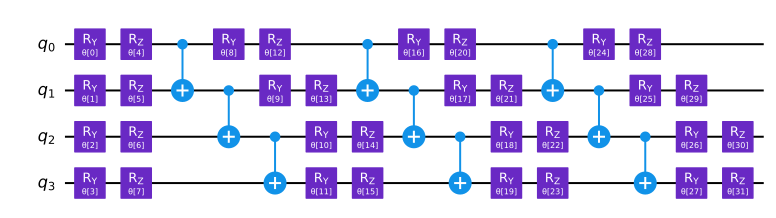

full entanglement:


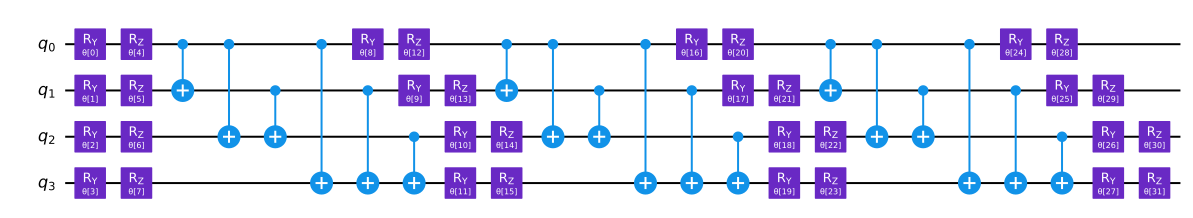

In [5]:
from qiskit.circuit.library import EfficientSU2
entanglements = ["linear", "full"]
for entanglement in entanglements:
    form = EfficientSU2(num_qubits=4, entanglement=entanglement)
    print(f"{entanglement} entanglement:")
    # We initialize all parameters to 0 for this demonstration
    display(form.decompose().draw(fold=-1))

深さ設定が $d$ に設定されていると仮定します。次に、RyRz には $2n\times (d+1)$ のパラメーターがあり、Ry (図示せず) には $n\times (d+1)$ のパラメーターがあります。

## Qiskit での VQE の実装

最初に次のライブラリをインポートする必要があります。 

In [6]:
# pylint: disable=line-too-long
import matplotlib.pyplot as plt
import qiskit
from qiskit.algorithms import VQE
import qiskit_nature
import qiskit_nature.problems.second_quantization
import qiskit_nature.drivers.second_quantization
import qiskit_nature.transformers.second_quantization.electronic
import qiskit_nature.algorithms
from qiskit_nature.drivers import Molecule

### シミュレーターでの VQE の実行

さまざまな原子間距離における LiH の基底状態エネルギーの計算を示します。分子のドライバーは、そのような距離ごとに作成する必要があります。この実験では、使用される量子ビットの数を減らすために、コアを凍結し、2 つの空軌道を削除していることに注意してください。まず、原子間距離を取得し、適切な量子ビット演算子 $H$ と演算子に関するその他の情報を返す関数を定義します。

In [7]:
def get_qubit_op(molecule,remove_orbitals):
    driver = qiskit_nature.drivers.second_quantization.ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=qiskit_nature.drivers.second_quantization.ElectronicStructureDriverType.PYSCF)

    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = qiskit_nature.problems.second_quantization.ElectronicStructureProblem(
        driver,
        remove_orbitals)

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = qiskit_nature.mappers.second_quantization.ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = qiskit_nature.converters.second_quantization.QubitConverter(mapper,two_qubit_reduction=True)
    reducer = qiskit.opflow.TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

まず、量子ビット演算子と古典的な正確な固有ソルバーを使用して、正確な基底状態エネルギーが計算されます。その後、初期状態 $|\psi\rangle$ が作成され、VQE インスタンスはこれを使用して最終的な状態 $\min_{\theta}(|\psi(\theta)\rangle)$ を生成します。正確な結果と各原子間距離での VQE 結果が保存されます。 `vqe.run(backend)['energy'] + shift`によって得られる結果が、量 $\min_{\theta}\left(\langle \psi(\theta)|H|\psi(\theta) と同等であることに注目してください。 \rangle\right)$、ここで最小値は必ずしもグローバル最小値であるとは限りません。

`VQE(qubit_op, var_form, optimizer, 'matrix')`で VQE インスタンスを初期化する場合、$|\psi(\theta)\rangle$ 上の $H$ の期待値は行列の乗算を通じて直接計算されます。ただし、実際の量子デバイス、または`VQE(qubit_op, var_form, optimizer, 'paulis')`を備えた`qasm_simulator`などの真のシミュレーターを使用する場合、期待値の計算はより複雑になります。ハミルトニアンは、パウリ文字列の合計として表すことができ、各パウリ項は、使用されるマッピングによって指定される量子ビットに作用します。各パウリ文字列には、$|\psi(\theta)\rangle$ に対応する回路に追加された対応する回路があります。その後、これらの回路がそれぞれ実行され、その結果すべてが $|\psi(\theta)\rangle$ 上の $H$ の期待値を決定するために使用されます。次の例では、VQE インスタンスを`matrix`モードで初期化するため、期待値は行列の乗算によって直接計算されます。

次のコード スニペットの実行が完了するまでに数分かかる場合があることに注意してください。 

In [8]:
def exact_solver(problem, converter):
    solver = qiskit_nature.algorithms.NumPyMinimumEigensolverFactory()
    calc = qiskit_nature.algorithms.GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

backend = qiskit.BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = qiskit.algorithms.optimizers.SLSQP(maxiter=5)

# pylint: disable=undefined-loop-variable
for dist in distances:
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["Li", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    (qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op(molecule,
                                                                [qiskit_nature.transformers.second_quantization.electronic.FreezeCoreTransformer(
                                                                    freeze_core=True,
                                                                    remove_orbitals=[-3,-2])])
    result = exact_solver(problem,converter)
    exact_energies.append(result.total_energies[0].real)
    init_state = qiskit_nature.circuit.library.HartreeFock(num_spin_orbitals, num_particles, converter)
    var_form = qiskit_nature.circuit.library.UCCSD(converter,
                     num_particles,
                     num_spin_orbitals,
                     initial_state=init_state)
    vqe = VQE(var_form, optimizer, quantum_instance=backend)
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(f"Interatomic Distance: {np.round(dist, 2)}",
          f"VQE Result: {vqe_result:.5f}",
          f"Exact Energy: {exact_energies[-1]:.5f}")

print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -7.04751 Exact Energy: -7.04791
Interatomic Distance: 0.7 VQE Result: -7.50392 Exact Energy: -7.50400
Interatomic Distance: 0.9 VQE Result: -7.72278 Exact Energy: -7.72283
Interatomic Distance: 1.1 VQE Result: -7.82516 Exact Energy: -7.82520
Interatomic Distance: 1.3 VQE Result: -7.86886 Exact Energy: -7.86890
Interatomic Distance: 1.5 VQE Result: -7.88210 Exact Energy: -7.88214
Interatomic Distance: 1.7 VQE Result: -7.87917 Exact Energy: -7.87920
Interatomic Distance: 1.9 VQE Result: -7.86788 Exact Energy: -7.86799
Interatomic Distance: 2.1 VQE Result: -7.85312 Exact Energy: -7.85320
Interatomic Distance: 2.3 VQE Result: -7.83763 Exact Energy: -7.83772
Interatomic Distance: 2.5 VQE Result: -7.82324 Exact Energy: -7.82343
Interatomic Distance: 2.7 VQE Result: -7.81116 Exact Energy: -7.81142
Interatomic Distance: 2.9 VQE Result: -7.80195 Exact Energy: -7.80215
Interatomic Distance: 3.1 VQE Result: -7.79516 Exact Energy: -7.79545
Interatomic Distance

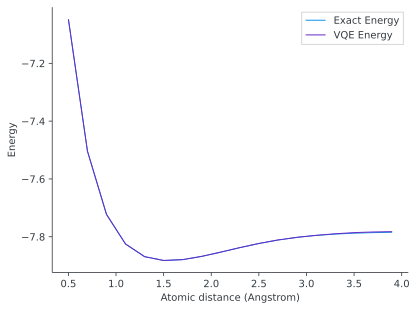

In [9]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

VQE の結果は正確な結果に非常に近いため、正確なエネルギー曲線は VQE 曲線によって隠されていることに注意してください。

### ノイズの多いシミュレーターで VQE を実行する

ここでは、ノイズの多いシミュレーターとエラー軽減を使用して、H$_2$ の基底状態エネルギーを計算します。

まず、分子のハミルトニアンを表す量子ビット演算子を準備します。

In [10]:
molecule = Molecule(
    geometry=[["H", [0.0, 0.0, -0.3625]],
              ["H", [0.0, 0.0, 0.3625]]],
    multiplicity=1,charge=0)

(qubit_op, num_particles, num_spin_orbitals,
                             problem, converter) = get_qubit_op(molecule, None)

ここで、IBM Quantum プロバイダーからデバイス カップリング マップとノイズ モデルをロードし、量子インスタンスを作成して、エラーの軽減を可能にします。

In [11]:
from qiskit.providers.fake_provider import FakeManila
from qiskit.providers.aer.noise import NoiseModel # pylint: disable=import-error, no-name-in-module"
backend = Aer.get_backend('aer_simulator')
device = FakeManila()
NOISE_MODEL = NoiseModel.from_backend(device)
coupling_map = device.configuration().coupling_map
qi = qiskit.utils.QuantumInstance(backend,
                    coupling_map=coupling_map,
                    noise_model=NOISE_MODEL,
                    measurement_error_mitigation_cls=qiskit.utils.mitigation.CompleteMeasFitter)

最後に、オプティマイザー、変分形式、および VQE インスタンスを構成する必要があります。 2 量子ビット ゲートの数が増えると回路の深さが増すにつれてノイズの影響が大きくなるため、UCCSD ではなくヒューリスティック変分形式 (RYRZ) を使用します。 RYRZ は UCCSD よりもはるかに浅い回路を備えており、使用する量子ビット ゲートの数が大幅に少なくなります。

次のコードの実行が完了するまでに数分かかる場合があります。

In [12]:
result = exact_solver(problem,converter)
exact_energies.append(result.total_energies)

print("Exact Result:", result.total_energies)
optimizer = qiskit.algorithms.optimizers.SPSA(maxiter=100)
var_form = EfficientSU2(qubit_op.num_qubits, entanglement="linear")
vqe = VQE(var_form, optimizer=optimizer,quantum_instance=qi)
vqe_calc=vqe.compute_minimum_eigenvalue(qubit_op)
vqe_result=np.real(problem.interpret(vqe_calc).total_energies)
print("VQE Result:", vqe_result)

Exact Result: [-1.13722138]
VQE Result: [-1.05786983]


ノイズ軽減を有効にすると、結果が化学的精度 (正確な結果の 0.0016 ハートリー以内であると定義) の範囲内に収まらない場合でも、正確な解にかなり近くなります。 

## 問題点

1. ハミルトニアン $H$ が与えられますが、その基底状態は最大量子もつれ $n$ 量子ビット状態に近いことが保証されています。どの変分形式 (複数の形式) が $H$ の基底状態エネルギーを効率的かつ正確に学習できる可能性があるかを説明してください。また、独自の変分形式を作成し、それがこのハミルトニアンでの使用に適している理由を説明して答えることもできます。
2. COBYLA オプティマイザー、1000 ショットの`qasm_simulator` 、および 60 パウリ文字列のハミルトニアンを使用する場合に、最適化の反復ごとに実行される回路評価の数を計算します。
3. VQE を使用して、原子間距離 $1.3$Å の BeH$_2$ の基底状態エネルギーを推定します。 `atom="Li .0 .0 .0; H .0 .0 " + str(dist)` `atom="Be .0 .0 .0; H .0 .0 -" + str(dist) + "; H .0 .0 " + str(dist)`置き換えることで、関数`get_qubit_op(dist)`を再利用できます。 `atom="Be .0 .0 .0; H .0 .0 -" + str(dist) + "; H .0 .0 " + str(dist)` 、 `get_qubit_op(1.3)`で関数を呼び出します。空軌道を削除しても、この分子の化学的精度は維持されないことに注意してください。ただし、必要な量子ビットの数を 6 まで下げる (これにより、ほとんどのラップトップで効率的なシミュレーションが可能になる) ためには、精度の低下は許容されます。この演習の範囲を超えていますが、興味のある読者は、化学的精度を失うことなく、量子ビットのテーパリング操作を使用して、必要な量子ビットの数を 7 に減らすことができます。

## 参考文献

1. ペルッツォ、アルベルト 他「フォトニック量子プロセッサ上の変分固有値ソルバー」*ネイチャーコミュニケーションズ*5 (2014): 4213.
2. グリフィス、デヴィッド J.、ダレル F. シュレーター。量子力学の入門。*ケンブリッジ大学出版局*、2018年。
3. シェンデ、ヴィヴェク V.、イーゴリ L. マルコフ、スティーブン S. ブロック。 「最小限のユニバーサル 2 量子ビット cnot ベースの回路」 arXiv プレプリント quant-ph/0308033 (2003)。
4. カンダラ、アビナフ、他。 「小分子と量子磁石用のハードウェア効率の高い変分量子固有ソルバー」ネイチャー 549.7671 (2017): 242.

In [13]:
# pylint: disable=unused-import
import qiskit.tools.jupyter
%qiskit_version_table